In [4]:
import json
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.rcParams["figure.figsize"] = (20, 10)

## Training Environments
Different configurations of agents and thus differents dynamic of price and volume to train the rl agent


## Orderbook

In [44]:
result_dir = Path("simulation_result/multi/run1")
train_dirs = os.listdir(result_dir / 'train')
validate_dirs = os.listdir(result_dir / 'validate')

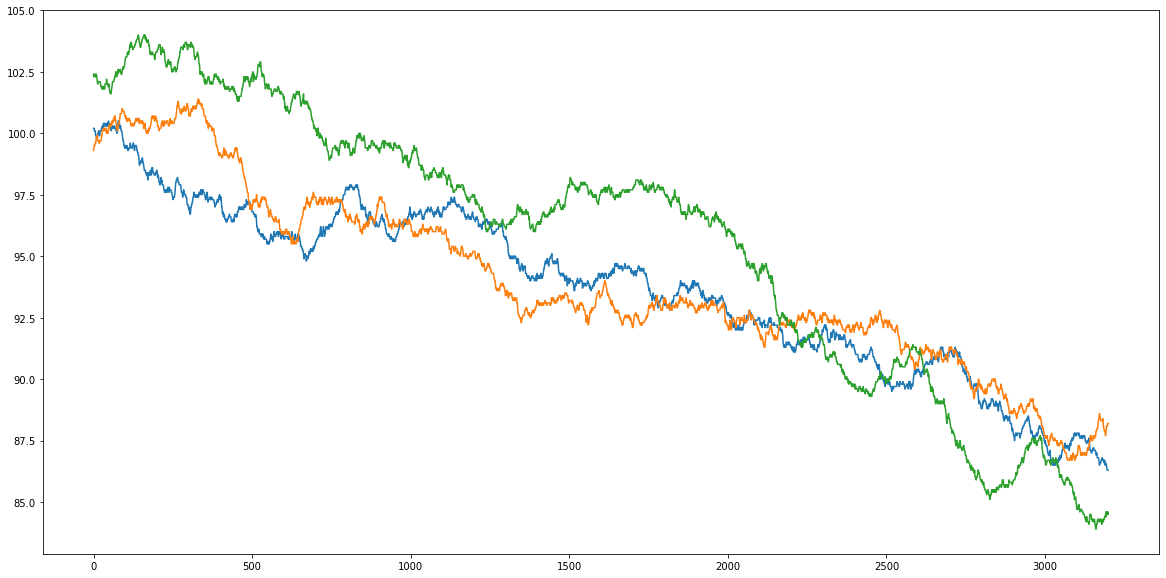

In [31]:
# train
for train_dir in train_dirs:
    train_dir = result_dir / 'train' / train_dir
    security_path = train_dir / "TSMC.json"
    agent_path = train_dir / "agent.json"
    # tsmc = pd.read_json(security_path)
    # plt.plot(tsmc['close'], color = 'r')
    market = json.loads(security_path.read_text())
    plt.plot(market['price'][100:])

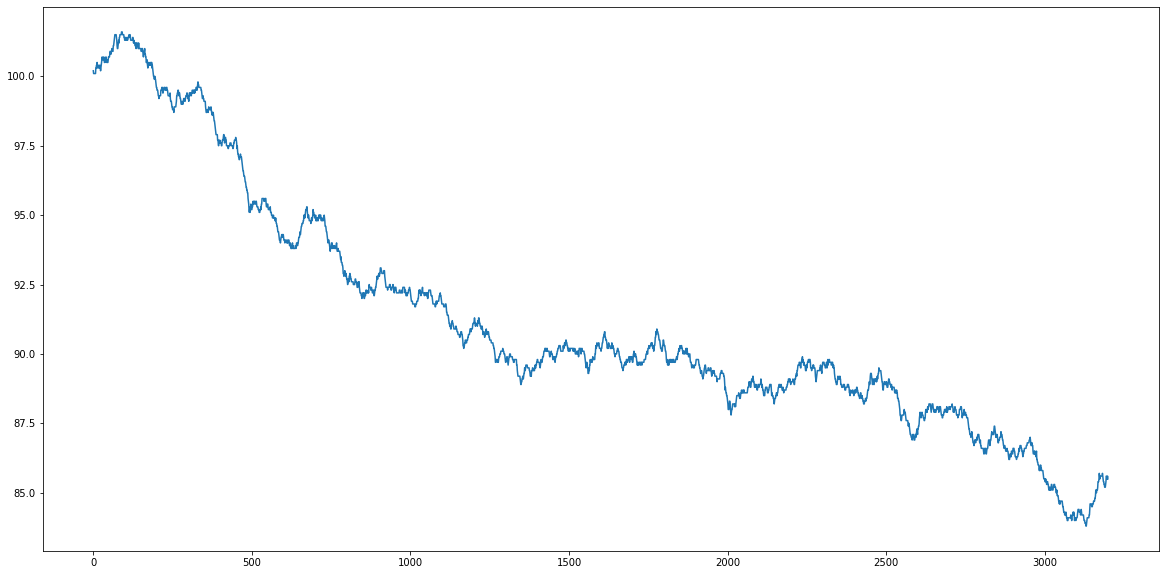

In [47]:
# validate
for validate_dir in validate_dirs:
    validate_dir = result_dir / 'validate' / validate_dir
    security_path = validate_dir / "TSMC.json"
    agent_path = validate_dir / "agent.json"
    market = json.loads(security_path.read_text())
    plt.plot(market['price'][100:])


In [51]:
import time
from IPython import display
from IPython.display import clear_output

for bids, asks in zip(market['bid_five_price'], market['ask_five_price']):
    length = min(len(bids), len(asks))
    bid_prices = list(bids.keys())
    bid_volumes = list(bids.values())
    ask_prices = list(asks.keys())
    ask_volumes = list(asks.values())
    clear_output(wait=True)
    display.display(pd.DataFrame([bid_prices, bid_volumes, ask_prices, ask_volumes], index=['bid_price', 'bid_volumn', 'ask_price', 'ask_volumn']).T)
    time.sleep(0.2)

,bid_price,bid_volumn,ask_price,ask_volumn
0,101.8,14,99.8,12
1,101.7,18,99.9,12
2,101.6,11,100.0,21
3,101.5,17,100.1,15
4,101.4,13,100.2,20


KeyboardInterrupt: 

## Agent

In [15]:
agent = pd.read_json(agent_path)
group_names = agent.columns
num_of_timesteps = len(agent[group_names[0]]['cash'])
print(group_names)
print(agent[agent.columns[0]].index)

Index(['rl_100', 'pr_300'], dtype='object')
Index(['cash', 'TSMC', 'wealth', 'average_cost', 'group_bids_volume',
       'group_asks_volume', 'initial_wealth_by_agent', 'initial_cash_by_agent',
       'initial_security_by_agent', 'returns_by_agent', 'timestep_bid',
       'timestep_ask'],
      dtype='object')


### Holdings

#### Initial state

In [16]:
num_agent = 0
total_cash, total_TSMC = 0, 0
zi_cash, zi_TSMC = 0, 0
for group_name in group_names:
    if 'dh' in group_name:
        continue
    elif 'zi' in group_name:
        zi_cash += sum(agent[group_name]['initial_cash_by_agent'])
        zi_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
    else:
        total_cash += sum(agent[group_name]['initial_cash_by_agent'])
        total_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
        num_agent += len(agent[group_name]['initial_cash_by_agent'])

print(f"Number of agents: {num_agent}")
print(f"Total TSMC: {total_TSMC} Total cash: {total_cash}")
print(f"Average TSMC: {total_TSMC // num_agent} Average cash: {total_cash // num_agent}")
print(f"ZI TSMC: {zi_TSMC} ZI cash: {zi_cash}")
if 'dh_1' in group_names:
    print(f"Dahoo cash: {agent['dh_1']['initial_cash_by_agent'][0]}")

Number of agents: 400
Total TSMC: 11629 Total cash: 118217977
Average TSMC: 29 Average cash: 295544
ZI TSMC: 0 ZI cash: 0


#### Wealth

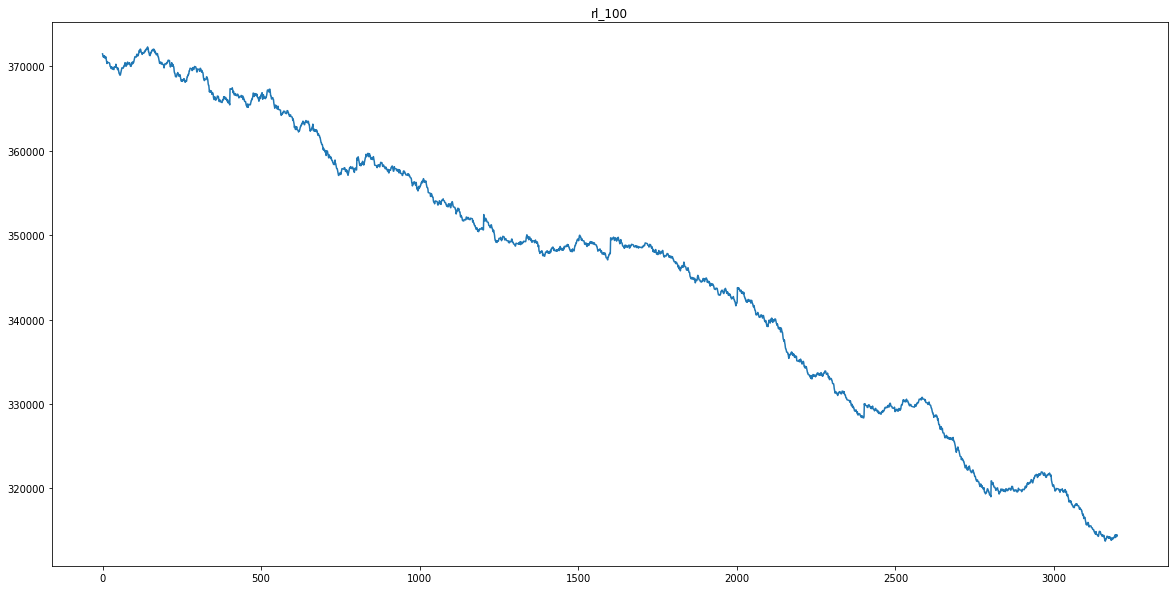

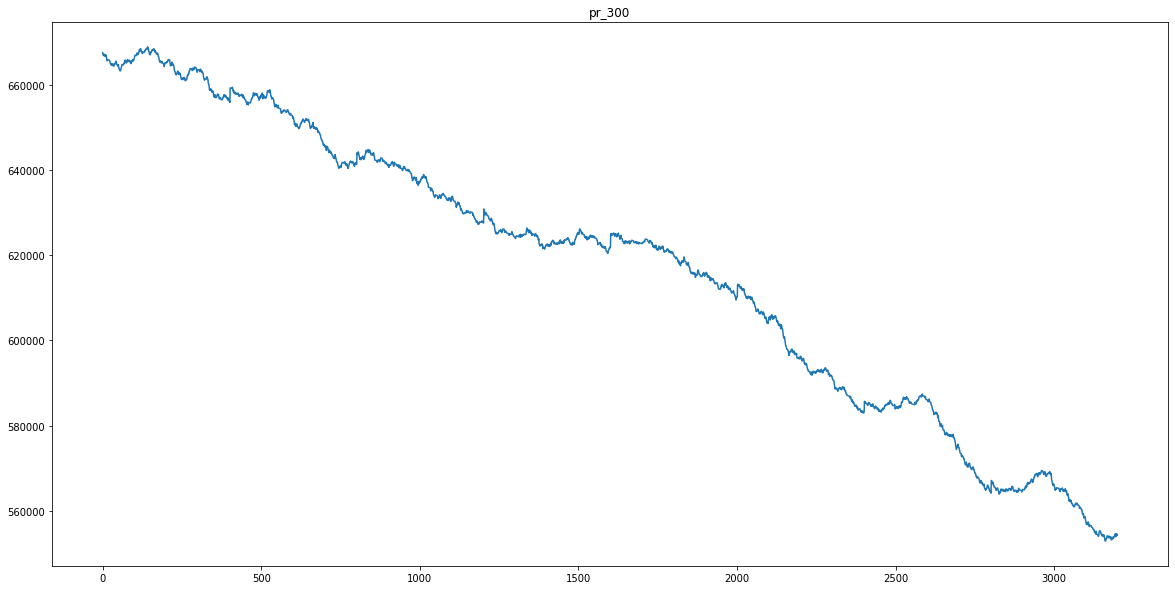

In [17]:
# for agent_type in agent.columns:
for group_name in agent.columns:
    plt.figure(figsize=(20, 10))
    plt.plot(agent[group_name]['wealth'])
    plt.title(group_name)
    plt.show()

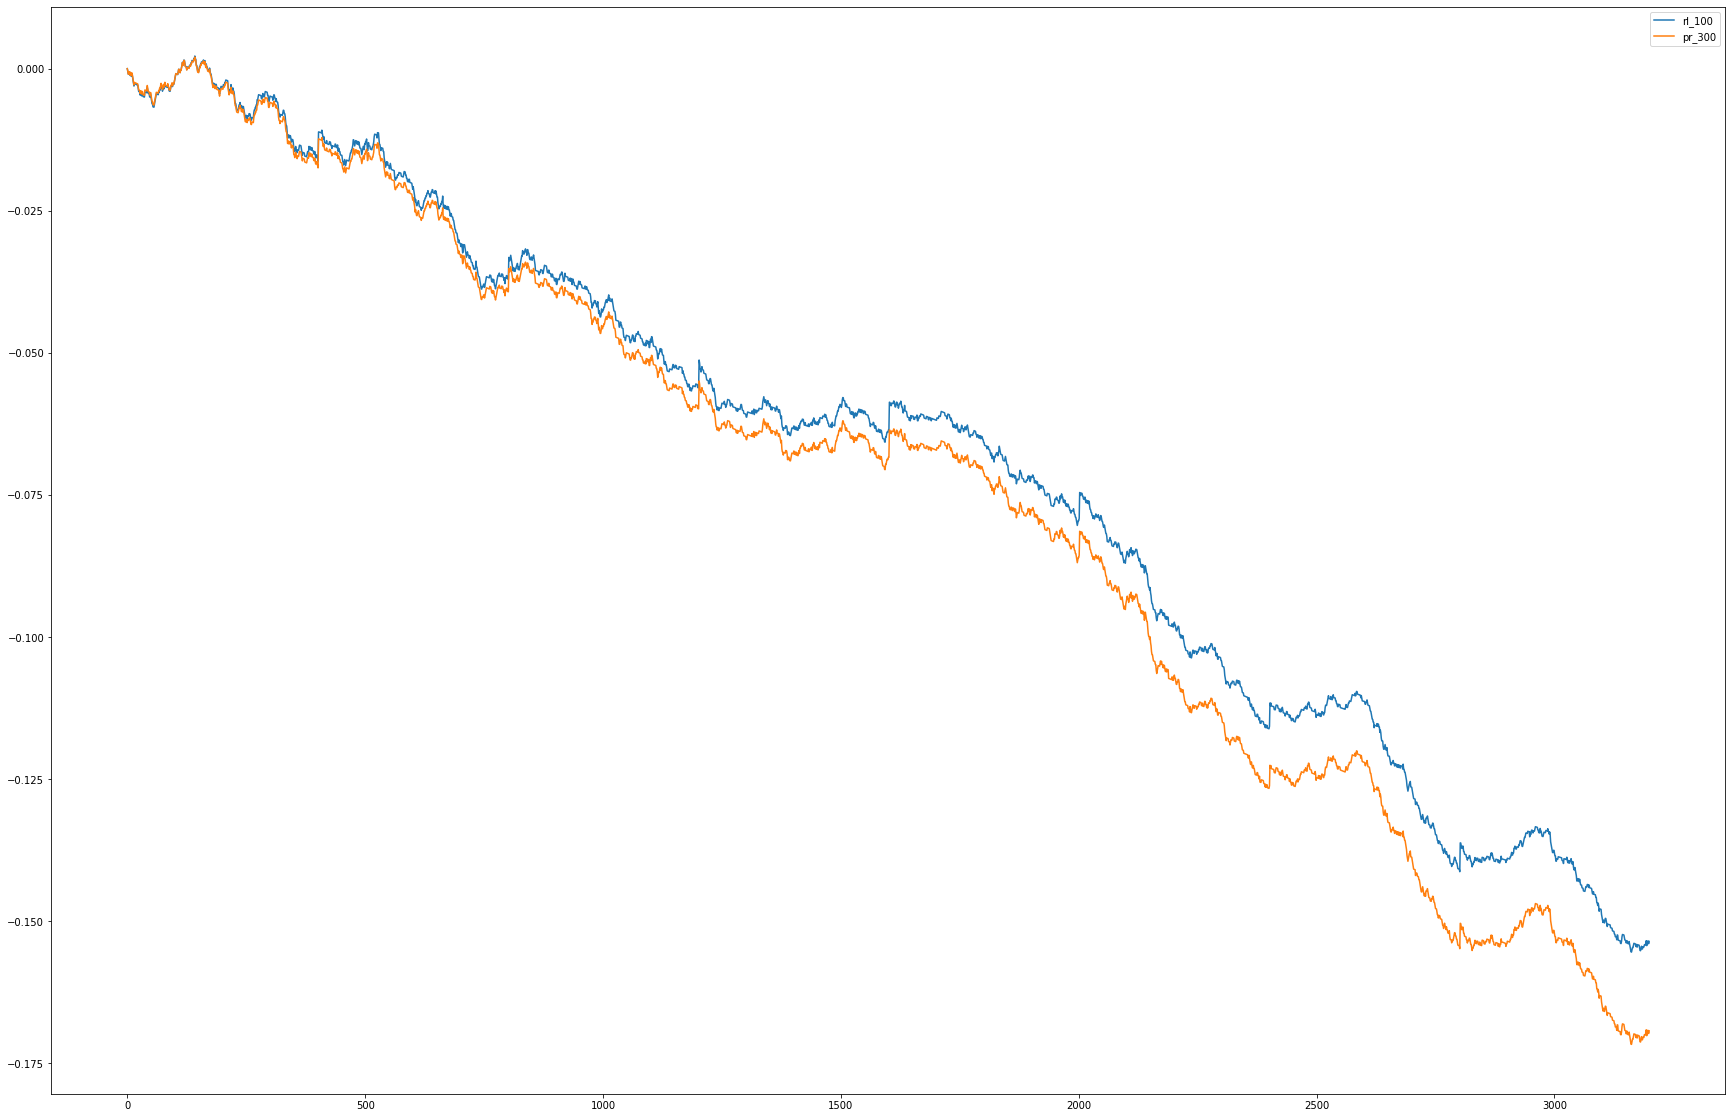

In [18]:
# normalize 
wealth = np.array([agent[group_name]['wealth'] for group_name in group_names])
std_wealth = (wealth - wealth[:, 0].reshape(-1, 1)) / wealth[:, 0].reshape(-1, 1)

plt.figure(figsize=(30, 20))
for i, group_name in enumerate(agent.columns):
    plt.plot(std_wealth[i], label = group_names[i])
plt.legend()

#### Cash

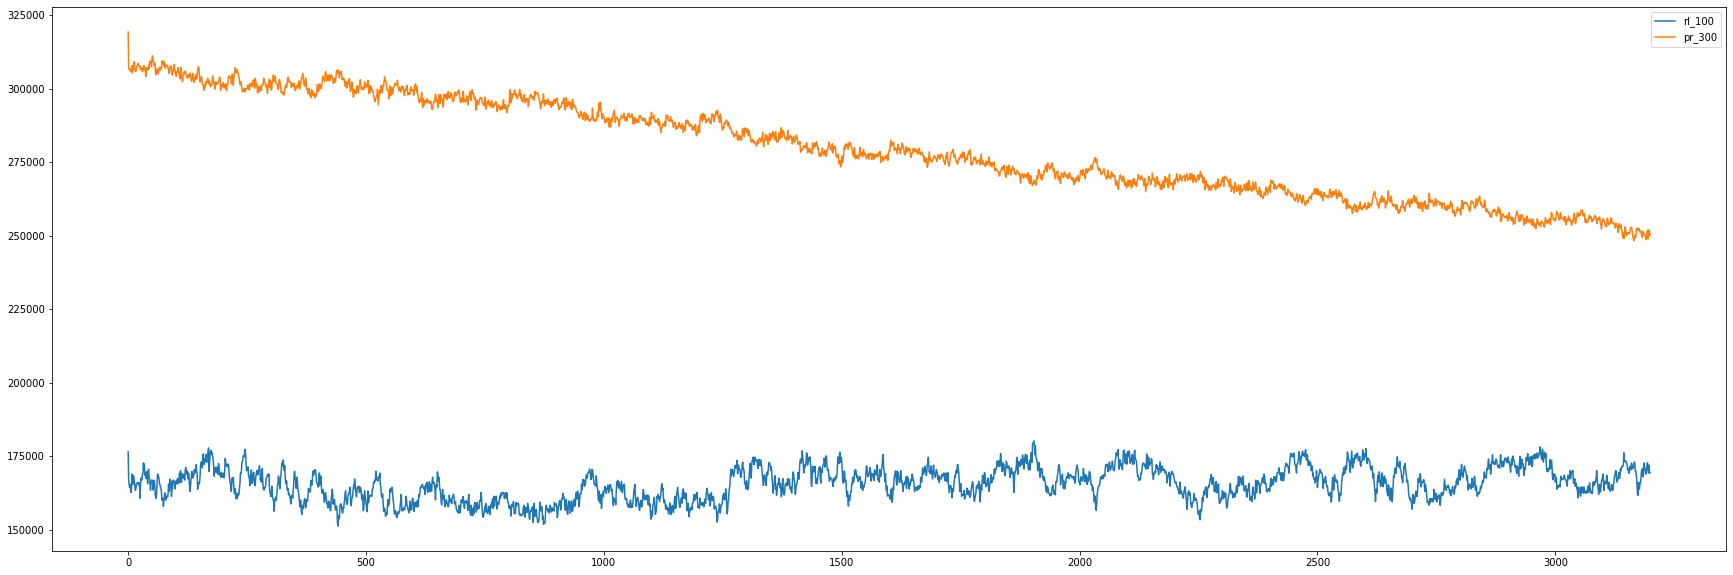

In [22]:
plt.figure(figsize=(30, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['cash'], label = group_names[i])
plt.legend()
plt.show()

#### Security

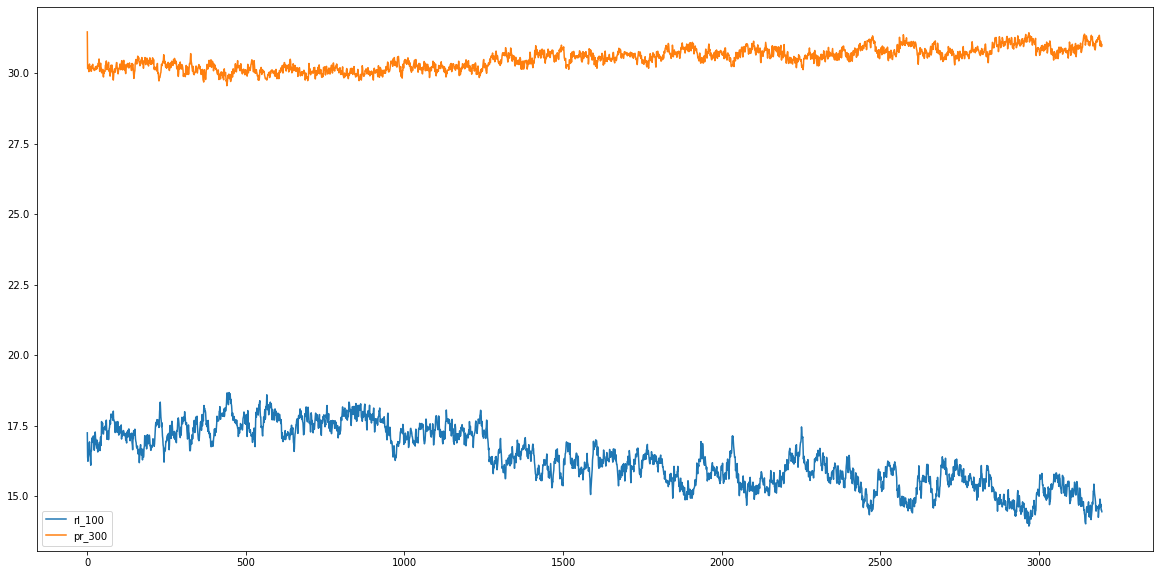

In [21]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['TSMC'], label = group_names[i])
plt.legend()
plt.show()

#### Portfolio

In [23]:
plt.figure(figsize=(20, 10))

close_price = tsmc['close'].to_numpy()
for group_name in group_names:
    security_value = close_price * np.array(agent[group_name]['TSMC']) * 100
    security_propotion = security_value / (np.array(agent[group_name]['cash'])  + security_value)
    plt.plot(security_propotion)
    plt.title(group_name, size = 20)
    plt.show()

NameError: name 'tsmc' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
# baseline_return = pow(1.01, 100) / 2
# for group_name in group_names:
#     plt.figure(figsize=(20, 10))
#     plt.axhline(y = baseline_return)
#     plt.scatter(agent[group_name]['initial_wealth_by_agent'], np.array(agent[group_name]['returns_by_agent']))
#     plt.xlabel('Initial wealth')
#     plt.ylabel('Return')
#     plt.title(f"{group_name}")
#     plt.show()

#### Average cost

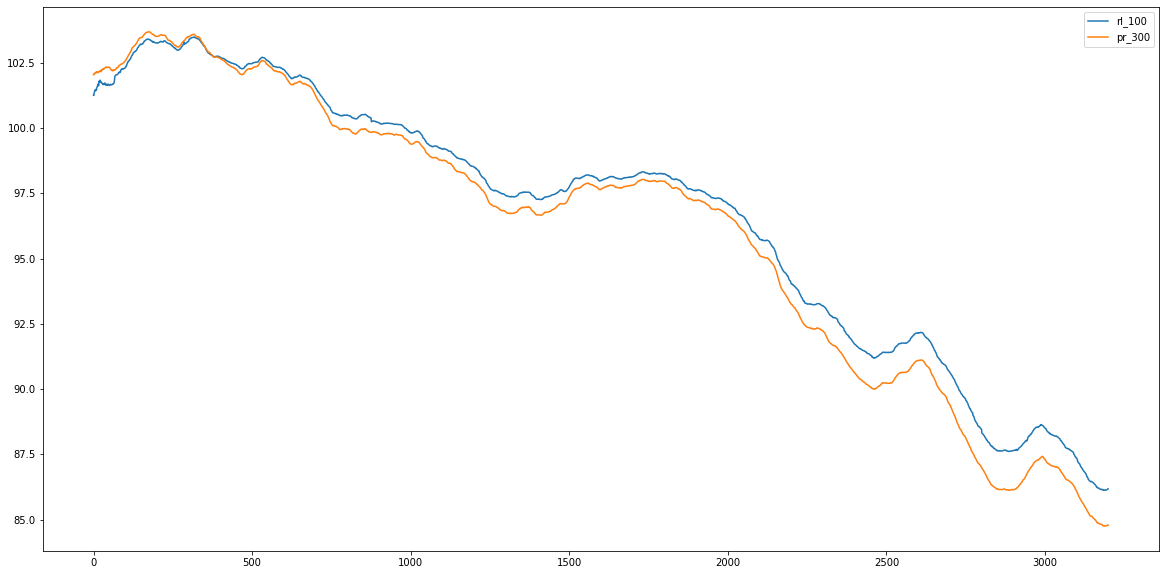

In [24]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['average_cost'], label = group_names[i])
plt.legend()

### Orders

#### Number

In [25]:
agent['rl_100']

cash                         [176557.14, 167220.8, 165570.09, 164432.27, 16...
TSMC                         [17.24, 16.38, 16.23, 16.36, 16.42, 16.49, 16....
wealth                       [371496.46, 371341.98, 371143.98, 371124.17, 3...
average_cost                 [101.25, 101.25, 101.34, 101.38, 101.45, 101.4...
group_bids_volume            [91.0, 182.0, 298.0, 387.0, 488.0, 579.0, 684....
group_asks_volume            [87.0, 173.0, 266.0, 352.0, 444.0, 529.0, 597....
initial_wealth_by_agent      [2011872.7977678091, 1415416.9584374663, 11541...
initial_cash_by_agent        [1000000, 707106, 577350, 500000, 447213, 4082...
initial_security_by_agent    [{'TSMC': 100}, {'TSMC': 70}, {'TSMC': 57}, {'...
returns_by_agent             [-0.096113475952532, -0.10156339980279301, -0....
timestep_bid                 [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {...
timestep_ask                 [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {...
Name: rl_100, dtype: object

In [26]:
agent['pr_300']

cash                         [319325.74, 307459.62, 306606.65, 306339.44, 3...
TSMC                         [31.47, 30.17, 30.23, 30.27, 30.17, 30.06, 30....
wealth                       [667494.96, 667215.8, 666861.21, 666832.15, 66...
average_cost                 [102.04, 102.04, 102.09, 102.09, 102.1, 102.09...
group_bids_volume            [373.0, 720.0, 1109.0, 1476.0, 1862.0, 2232.0,...
group_asks_volume            [377.0, 768.0, 1135.0, 1500.0, 1894.0, 2285.0,...
initial_wealth_by_agent      [6035618.393303428, 4266490.3312677555, 348258...
initial_cash_by_agent        [3000000, 2121320, 1732050, 1500000, 1341640, ...
initial_security_by_agent    [{'TSMC': 300}, {'TSMC': 212}, {'TSMC': 173}, ...
returns_by_agent             [-0.068643730651205, -0.014731649760713, -0.06...
timestep_bid                 [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'102...
timestep_ask                 [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {'103...
Name: pr_300, dtype: object

#### Each group

In [25]:
from collections import defaultdict

t = list(group_names)
for group_name in group_names:
    if 'zi' in group_name:
        continue
    bids_timestep, bids_price, bids_volume, asks_timestep, asks_price, asks_volume = [], [], [], [], [], []
    bids_price_volume = defaultdict(float)
    asks_price_volume = defaultdict(float)
    
    for i in range(len(agent[group_name]['timestep_bid'])):
        for price, volume in agent[group_name]['timestep_bid'][i].items():
            bids_timestep.append(i)
            bids_price.append(float(price))
            bids_volume.append(volume)
            bids_price_volume[float(price)] += volume
        for price, volume in agent[group_name]['timestep_ask'][i].items():
            asks_timestep.append(i)
            asks_price.append(float(price))
            asks_volume.append(volume)
            asks_price_volume[float(price)] += volume
    
    bids_size = [ 400*(volume - min(bids_volume)) / max(bids_volume) - min(bids_volume) for volume in bids_volume]
    asks_size = [ 400*(volume - min(asks_volume)) / max(asks_volume) - min(asks_volume) for volume in asks_volume]
    plt.plot(tsmc['close'])
    plt.scatter(bids_timestep, bids_price, s = bids_size, c = 'r', marker = 6)
    plt.scatter(asks_timestep, asks_price, s = asks_size, c = 'g', marker = 7)
    plt.title(group_name)
    plt.show()
    plt.bar(list(bids_price_volume.keys()), list(bids_price_volume.values()), color = 'r')
    plt.bar(list(asks_price_volume.keys()), np.array(list(asks_price_volume.values())) * -1, color = 'g')
    plt.show()


NameError: name 'tsmc' is not defined

#### Propotion

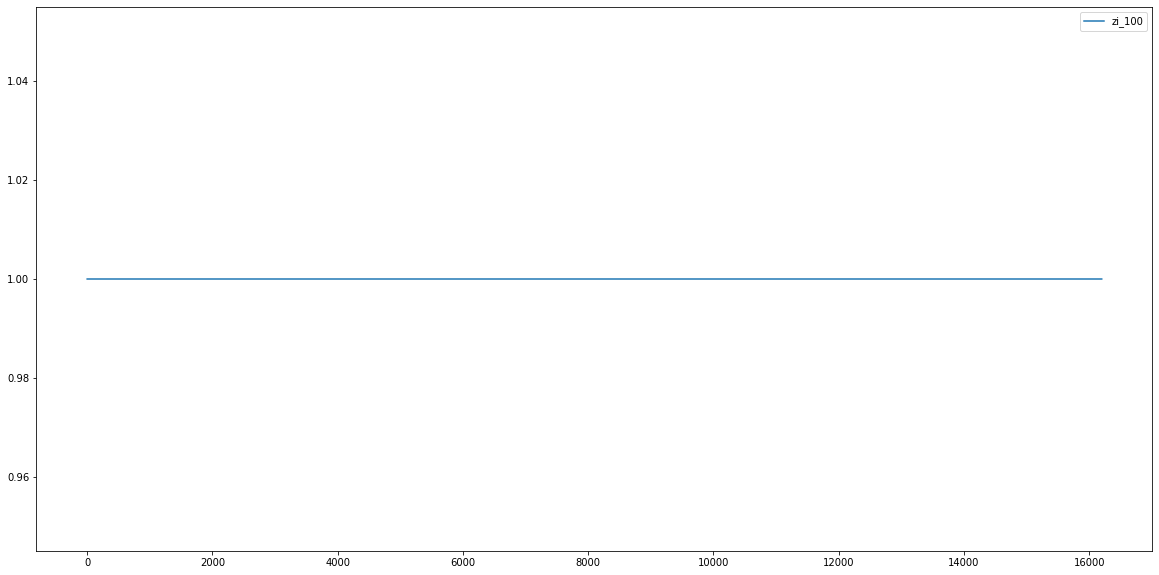

In [90]:
group_bids_volume = [agent.loc['group_bids_volume', group_name] for group_name in group_names]
group_bids_volume = np.array(group_bids_volume).T
group_bids_volume = group_bids_volume / group_bids_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(group_bids_volume[:, i], label = group_names[i])
# plt.ylim(0, 0.1)
plt.legend()

In [ ]:
group_asks_volume = [agent.loc['group_asks_volume', group_name] for group_name in group_names]
group_asks_volume = np.array(group_asks_volume).T
group_asks_volume = group_asks_volume / group_asks_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(-1 * group_asks_volume[:, i], label = group_names[i])

# plt.ylim(-0.3, 0.2)
plt.legend()

## Parameter tuning

### Different initial propotion of cash and security with only ZI

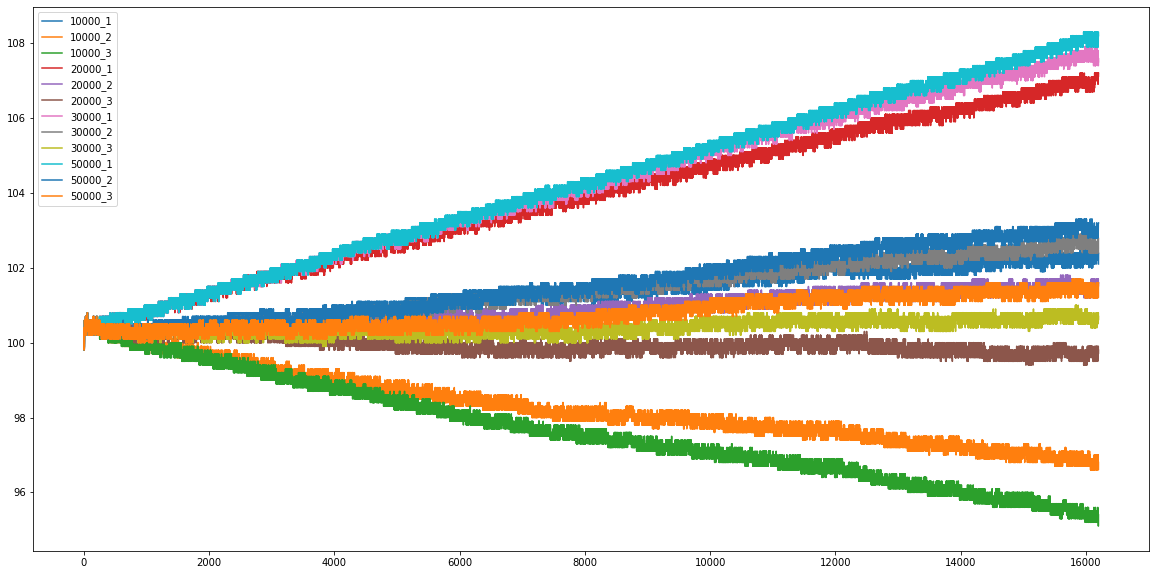

In [122]:
experiment_name = 'zi_security_cash_propotion'
cashes = [10000, 20000, 30000, 50000]
tsmc_nums = [1, 2, 3]
names = [f"{cash}_{tsmc_num}" for cash in cashes for tsmc_num in tsmc_nums]
for name in names:
    tmp = pd.read_json(f"result/{experiment_name}/{name}/TSMC.json")
    plt.plot(tmp['close'], label = name)
plt.legend()
plt.show()

# looks 30000:3 is fine

### Different initial propotion of cash and security

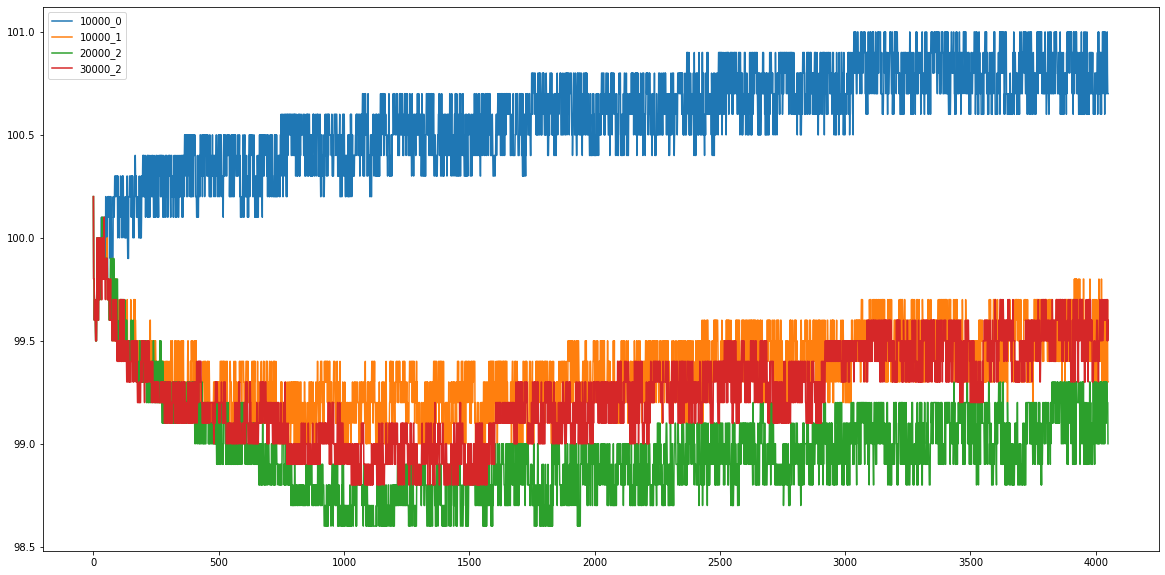

In [148]:
experiment_name = 'tr_security_cash_propotion'
cashes = [10000, 20000, 30000, 50000]
tsmc_nums = [0, 1, 2, 3]
names = [f"{cash}_{tsmc_num}" for cash in cashes for tsmc_num in tsmc_nums]
names = ['10000_0', '10000_1', '20000_2', '30000_2']
for name in names:
    tmp = pd.read_json(f"result/{experiment_name}/{name}/TSMC.json")
    plt.plot(tmp['close'], label = name)
plt.legend()
plt.show()

### Different numbers of trend and ZI 

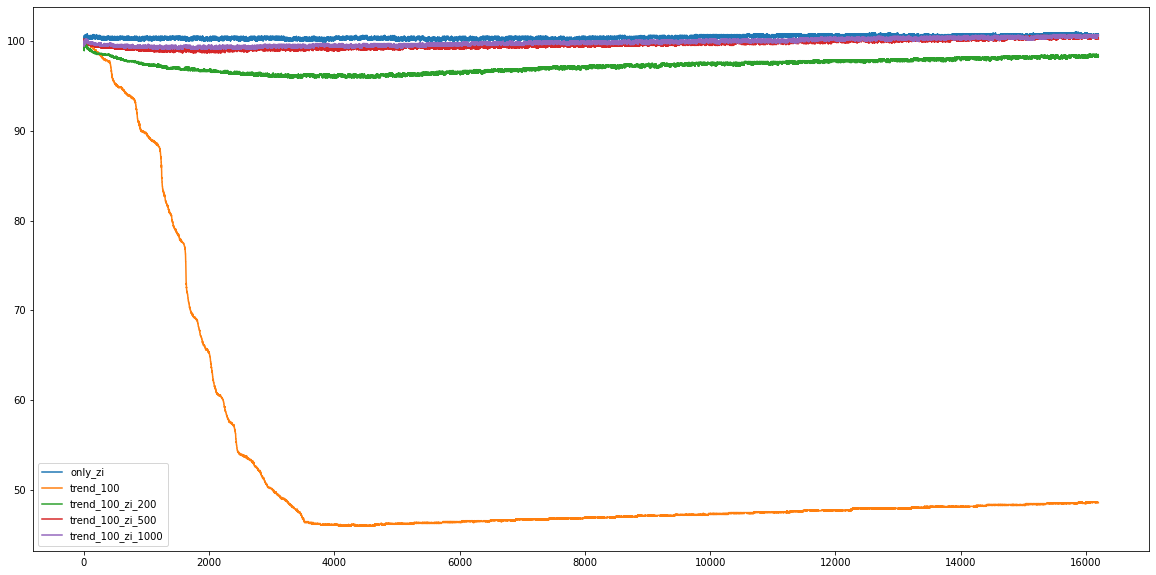

In [123]:
# zi : 10000, 1 other: 10000, 1
experiment_name = 'trend_and_zi_num'
names = ['only_zi', 'trend_100', 'trend_100_zi_200', 'trend_100_zi_500', 'trend_100_zi_1000']
for name in names:
    tmp = pd.read_json(f"result/{experiment_name}/{name}/TSMC.json")
    plt.plot(tmp['close'], label = name)
plt.legend()
plt.show()

### Trend configuration

### Dahoo

#### Other agents have stock

Configure
Number of agents: 850
zi: 30000_3
other: 20000_2
Total TSMC: 30610 Total cash: 310185631 (3.1e8)
Average TSMC: 36 Average cash: 364924
ZI TSMC: 64690 ZI cash: 649250181 (6.4e8)

Total amount of cash is 9.5e8
Total amount of TSMC is 9.4e4
Total amount of wealth in the market is 1.9e9

Using 1%, 5%, 10%, 20%,...,100% -> 100% of cash of dahoo: 1.9e7, 9.5e7

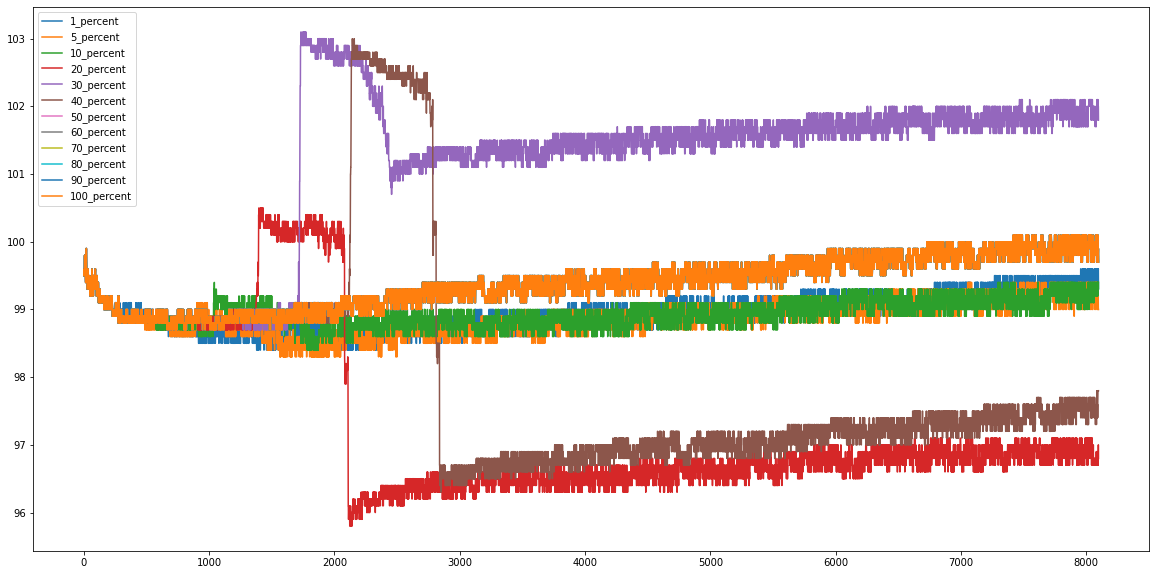

In [168]:
experiment_name = 'dahoo'
scale = [0.01, 0.05] + [0.1 * i for i in range(1, 11)]
cashes = [ int(i * 1.9e9) for i in scale]
names = [f"{int(cash//1.9e7)}_percent" for cash in cashes]

for name in names:
    tmp = pd.read_json(f"result/{experiment_name}/{name}/TSMC.json")
    plt.plot(tmp['close'], label = name)
plt.legend()
plt.show()

#### Other agents have no stock

In [ ]:
'''
Configure
Number of agents: 850
zi: 30000_3
other: 20000_2
Total TSMC: 30610 Total cash: 310185631 (3.1e8)
Average TSMC: 36 Average cash: 364924
ZI TSMC: 64690 ZI cash: 649250181 (6.4e8)

Total amount of cash is 9.5e8
Total amount of TSMC is 9.4e4
Total amount of wealth in the market is 1.9e9

Using 1%, 5%, 10%, 20%,...,100% -> 100% of cash of dahoo: 1.9e7, 9.5e7
'''

### Clear perid

In [ ]:
'''
Configure
Number of agents: 850
zi: 30000_3
other: 20000_2

The base of clear period is 200
Our timestep is 16200 and 200 is 1.23%
Test set: [1%(162), 200, 2%(324), 4%, 8%, 10%, 15%, 20%, 30%, 40%, 50%, 70%, 80%, 100%]
'''

## RL Agent

In [ ]:
rl_path = Path("rl_result/te/train")
rl_path = rl_path / "rl.json"
rl_states = json.loads(rl_path.read_text())

In [ ]:
# append data for maintaining the same length
rl_states['states'][-1]['action'] = rl_states['states'][-2]['action']
rl_states['states'][-1]['reward'] = rl_states['states'][-2]['reward']

In [ ]:
rl_dict = {}
for k, v in rl_states['states'][0].items():
    if type(v) != dict:
        rl_dict[k] = []
    else:
        for key in v.keys():
            rl_dict[key] = []

In [ ]:
for state in rl_states['states']:
    for k, v in state.items():
        if type(v) != dict:
            rl_dict[k].append(v)
        else:
            for key, value in v.items():
                rl_dict[key].append(value)

In [ ]:
rl_df = pd.DataFrame(rl_dict)
rl_df

Reward

In [ ]:
plt.plot(rl_df.wealth / rl_df.wealth[0])
plt.plot(rl_df.wealth_reward)

Action

In [ ]:
'''
1. Discrete 3 - BUY[0], SELL[1], HOLD[2]
2. Discrete 9 - TICK_-4[0], TICK_-3[1], TICK_-2[2], TICK_-1[3], TICK_0[4], TICK_1[5], TICK_2[6], TICK_3[7], TICK_4[8]
3. Discrete 5 - VOLUME_1[0], VOLUME_2[1], VOLUME_3[2], VOLUME_4[3], VOLUME_5[4],
'''
valid_action_rate = rl_df.is_valid.mean()
bid_rate = rl_df.action.apply(lambda x: int(x[0]) == 0).mean()
ask_rate = rl_df.action.apply(lambda x: int(x[1]) == 0).mean()
hold_rate = rl_df.action.apply(lambda x: int(x[2]) == 0).mean()
print(f"Bid rate: {bid_rate}\nAsk rate: {ask_rate}\nHold rate: {hold_rate}\nValid action rate: {valid_action_rate}")

In [ ]:
rl_orders = rl_states['orders']

In [ ]:
bid_x, bid_y = [], []
ask_x, ask_y = [], []
bid_sizes, ask_sizes = [], []
bid_colors, ask_colors = [], []
base_size = 200
for order in rl_orders:
    if order['bid_or_ask'] == 'BID':
        if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
    if order['bid_or_ask'] == 'ASK':
        if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])

In [ ]:
x = np.arange(len(tsmc['close']))
plt.figure(figsize=(80, 20))
plt.plot(x[4999: 5101], tsmc['close'][4999:5101])
plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
plt.show()